# Build Models

### Imports / Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNRegressor
from xgboost import XGBRegressor

In [2]:
# Set pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Read In Data

In [3]:
df = pd.read_csv("..\\Data\\NFLData.csv")
df = df[df['points'].notna() & df['avg_passing_epa'].notna()]
y_actual = df[df['points'].notna() & df['avg_passing_epa'].isna()]

## Exploration

In [4]:
def convert_to_decimal(time_value):
    if isinstance(time_value, str) and ':' in time_value:
        minutes, seconds = time_value.split(':')
        return float(minutes) + float(seconds) / 60
    return time_value  # Return as-is if already float or NaN

# Process both columns
df['team_top'] = df['team_top'].apply(convert_to_decimal).astype(float)
df['opp_top'] = df['opp_top'].apply(convert_to_decimal).astype(float)

In [5]:
df.isna().sum()

game_id                           0
season                            0
week                              0
team                              0
opponent                          0
points                            0
total_line                        0
avg_passing_epa                   0
avg_passing_cpoe                  0
avg_rushing_epa                   0
avg_receiving_epa                 0
avg_fg_pct                        0
avg_pat_pct                       0
avg_completions                   0
avg_attempts                      0
avg_passing_yards                 0
avg_passing_tds                   0
avg_passing_interceptions         0
avg_sacks_suffered                0
avg_sack_yards_lost               0
avg_sack_fumbles_lost             0
avg_carries                       0
avg_rushing_yards                 0
avg_rushing_tds                   0
avg_rushing_fumbles_lost          0
avg_rushing_first_downs           0
avg_receiving_fumbles_lost        0
avg_penalties               

In [6]:
numeric_cols = df.select_dtypes(include='number').columns

correlation_matrix = df[numeric_cols].corr()

In [7]:
correlation_matrix[correlation_matrix.abs() > 0.5].dropna(how='all', axis=0).dropna(how='all', axis=1)

,season,week,points,total_line,avg_passing_epa,avg_passing_cpoe,avg_rushing_epa,avg_receiving_epa,avg_fg_pct,avg_pat_pct,avg_completions,avg_attempts,avg_passing_yards,avg_passing_tds,avg_passing_interceptions,avg_sacks_suffered,avg_sack_yards_lost,avg_sack_fumbles_lost,avg_carries,avg_rushing_yards,avg_rushing_tds,avg_rushing_fumbles_lost,avg_rushing_first_downs,avg_receiving_fumbles_lost,avg_penalties,avg_penalty_yards,avg_punt_returns,avg_punt_return_yards,avg_kickoff_returns,avg_kickoff_return_yards,avg_fg_att,avg_points_scored,avg_def_tackles_solo,avg_def_tackles_with_assist,avg_def_tackle_assists,avg_def_tackles_for_loss,avg_def_tackles_for_loss_yards,avg_def_fumbles_forced,avg_def_sacks,avg_def_sack_yards,avg_def_qb_hits,avg_def_interceptions,avg_def_interception_yards,avg_def_pass_defended,avg_def_tds,avg_def_fumbles,avg_def_safeties,avg_points_against,team_top,opp_top
season,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.788957,0.752430,NaN,NaN,NaN,-0.783336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
week,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_line,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_passing_epa,NaN,NaN,NaN,NaN,1.000000,0.675809,NaN,0.920041,NaN,NaN,NaN,NaN,0.604857,0.643290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.775808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_passing_cpoe,NaN,NaN,NaN,NaN,0.675809,1.000000,NaN,0.723483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.572425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rushing_epa,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.609312,0.600744,NaN,0.635584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_receiving_epa,NaN,NaN,NaN,NaN,0.920041,0.723483,NaN,1.000000,NaN,NaN,NaN,NaN,0.605102,0.629771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.717398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_fg_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_pat_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
correlation_matrix['points'][correlation_matrix['points'].abs() > 0.05]

points                         1.000000
total_line                     0.193297
avg_passing_epa                0.253647
avg_passing_cpoe               0.218280
avg_rushing_epa                0.156441
avg_receiving_epa              0.210201
avg_attempts                  -0.101917
avg_passing_yards              0.123327
avg_passing_tds                0.143991
avg_passing_interceptions     -0.127500
avg_sacks_suffered            -0.183331
avg_sack_yards_lost            0.188103
avg_sack_fumbles_lost         -0.065135
avg_carries                    0.132808
avg_rushing_yards              0.161417
avg_rushing_tds                0.174507
avg_rushing_first_downs        0.149624
avg_punt_returns              -0.059144
avg_kickoff_returns           -0.055577
avg_kickoff_return_yards      -0.051434
avg_points_scored              0.217606
avg_def_tackles_with_assist   -0.069938
avg_def_qb_hits                0.084662
avg_def_interceptions          0.096471
avg_def_interception_yards     0.050951


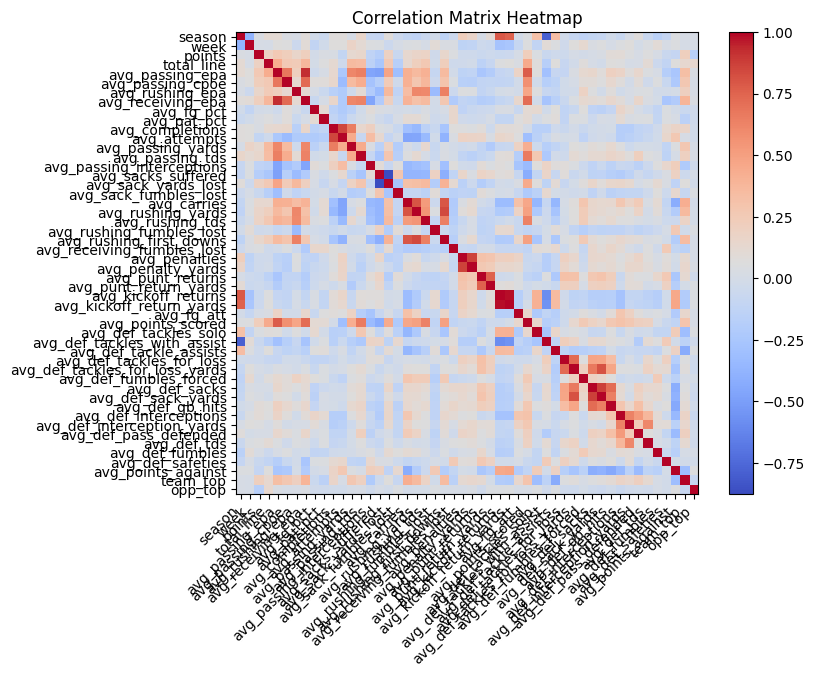

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Train-Test Split and Variable Selection

In [10]:
# Exclude highly correlated variables that are less highly coorelated with the target than the other variable correlated and information variables

exclude_cols = ["game_id", "season", "week", "team", "opponent", "opponent_team", "points", "avg_receiving_epa", "avg_passing_yards", "avg_attempts", "avg_sack_yards_lost", "avg_carries", "avg_rushing_first_downs",
                "avg_penalty_yards", "avg_punt_returns", "avg_kickoff_return_yards", "avg_def_tackles_for_loss", "avg_def_sacks", "avg_def_sack_yards", "avg_points_against"]
X = df.drop(columns=exclude_cols)
y = df['points']

In [11]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# Reset pandas settings
pd.reset_option('all')

C:\Users\tyler\AppData\Local\Temp\ipykernel_15048\4019361738.py:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\tyler\AppData\Local\Temp\ipykernel_15048\4019361738.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


In [13]:
X_train.columns

Index(['total_line', 'avg_passing_epa', 'avg_passing_cpoe', 'avg_rushing_epa',
       'avg_fg_pct', 'avg_pat_pct', 'avg_completions', 'avg_passing_tds',
       'avg_passing_interceptions', 'avg_sacks_suffered',
       'avg_sack_fumbles_lost', 'avg_rushing_yards', 'avg_rushing_tds',
       'avg_rushing_fumbles_lost', 'avg_receiving_fumbles_lost',
       'avg_penalties', 'avg_punt_return_yards', 'avg_kickoff_returns',
       'avg_fg_att', 'avg_points_scored', 'avg_def_tackles_solo',
       'avg_def_tackles_with_assist', 'avg_def_tackle_assists',
       'avg_def_tackles_for_loss_yards', 'avg_def_fumbles_forced',
       'avg_def_qb_hits', 'avg_def_interceptions',
       'avg_def_interception_yards', 'avg_def_pass_defended', 'avg_def_tds',
       'avg_def_fumbles', 'avg_def_safeties', 'team_top', 'opp_top'],
      dtype='object')

In [14]:
y_train

896    44.0
637    27.0
444    44.0
332    10.0
291    24.0
       ... 
71     32.0
106    18.0
270    19.0
435    34.0
102    14.0
Name: points, Length: 644, dtype: float64


## Models

### LASSO Regression to Potentially cut down on more features

In [15]:
X_train.columns

Index(['total_line', 'avg_passing_epa', 'avg_passing_cpoe', 'avg_rushing_epa',
       'avg_fg_pct', 'avg_pat_pct', 'avg_completions', 'avg_passing_tds',
       'avg_passing_interceptions', 'avg_sacks_suffered',
       'avg_sack_fumbles_lost', 'avg_rushing_yards', 'avg_rushing_tds',
       'avg_rushing_fumbles_lost', 'avg_receiving_fumbles_lost',
       'avg_penalties', 'avg_punt_return_yards', 'avg_kickoff_returns',
       'avg_fg_att', 'avg_points_scored', 'avg_def_tackles_solo',
       'avg_def_tackles_with_assist', 'avg_def_tackle_assists',
       'avg_def_tackles_for_loss_yards', 'avg_def_fumbles_forced',
       'avg_def_qb_hits', 'avg_def_interceptions',
       'avg_def_interception_yards', 'avg_def_pass_defended', 'avg_def_tds',
       'avg_def_fumbles', 'avg_def_safeties', 'team_top', 'opp_top'],
      dtype='object')

In [16]:
# Standard scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Fit a Lasso model with cross-validation to choose the best alpha (penalty strength)
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

In [18]:
# Get coefficients (non-zero ones are selected features)
lasso_coeffs = pd.Series(lasso.coef_, index=X.columns)
selected_features = lasso_coeffs[lasso_coeffs != 0]

In [19]:
print("Best alpha chosen:", lasso.alpha_)
print("\nSelected features and their coefficients:")
print(selected_features)

Best alpha chosen: 0.2600331260391356

Selected features and their coefficients:
total_line                    1.356662
avg_passing_cpoe              0.710909
avg_rushing_epa               0.462405
avg_pat_pct                   0.057085
avg_completions              -0.001401
avg_passing_interceptions    -0.126060
avg_sacks_suffered           -0.807731
avg_rushing_yards             0.133633
avg_rushing_tds               0.033985
avg_receiving_fumbles_lost    0.400532
avg_punt_return_yards         0.049404
avg_def_tackle_assists        0.093877
avg_def_fumbles_forced       -0.121085
avg_def_pass_defended        -0.355205
avg_def_safeties             -0.349683
team_top                      0.813336
opp_top                      -1.405770
dtype: float64


In [20]:
lasso_pred = lasso.predict(X_test_scaled)
mse = mean_squared_error(y_test, lasso_pred)
mae = mean_absolute_error(y_test, lasso_pred)
r2 = r2_score(y_test, lasso_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)

MSE: 102.16024271362787
MAE: 8.132220380759275
R²: 0.136959689993443


### TabPFN Regressor

In [21]:
# Instantiate the regressor
reg = TabPFNRegressor(device="cpu") 

In [22]:
# Fit the model
reg.fit(X_train, y_train)

c:\Users\tyler\Side_Projects\NFLMatchupPrediction\.venv\lib\site-packages\tabpfn\regressor.py:563: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


TabPFNRegressor(device='cpu')

In [23]:
# Make predictions
TPFN_pred = reg.predict(X_test)

In [24]:
# Evaluate
mse = mean_squared_error(y_test, TPFN_pred)
mae = mean_absolute_error(y_test, TPFN_pred)
r2 = r2_score(y_test, TPFN_pred)

In [25]:
print(f'MSE: {mse}\nMAE: {mae}\nR²: {r2}')

MSE: 101.12889380252547
MAE: 8.07687665798046
R²: 0.14567243049130796


### XGBoost Regressor

In [26]:
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [27]:
xgb_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print(f"MSE: {mse}\nMAE: {mae}\nR²: {r2}")

MSE: 114.9437457419673
MAE: 8.66171818603704
R²: 0.028965835207151458


### Baseline

In [28]:
y_test.describe()

count    162.000000
mean      23.530864
std       10.913649
min        0.000000
25%       16.000000
50%       23.000000
75%       32.000000
max       52.000000
Name: points, dtype: float64

In [29]:
avg_pred = []
for i in range(0,162):
    avg_pred.append(23.530864)

In [30]:
mse = mean_squared_error(y_test, avg_pred)
mae = mean_absolute_error(y_test, avg_pred)
r2 = r2_score(y_test, avg_pred)

print(f"MSE: {mse}\nMAE: {mae}\nR²: {r2}")

MSE: 118.37250419143427
MAE: 8.772748049382715
R²: -4.440892098500626e-16


### Ensemble Model with the Previous Models

In [31]:
# CREATE AN ENSEMBLE MODEL WITH ALL THE PREVIOUS MODELS

In [32]:
ens_pred = (lasso_pred + TPFN_pred + xgb_pred) / 3

In [33]:
mse = mean_squared_error(y_test, ens_pred)
mae = mean_absolute_error(y_test, ens_pred)
r2 = r2_score(y_test, ens_pred)

print(f"MSE: {mse}\nMAE: {mae}\nR²: {r2}")

MSE: 102.52532734813336
MAE: 8.157719953015274
R²: 0.13387548866646026
